In [1]:
from google.colab import drive    # 드라이브 마운팅
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# 전이 학습!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
from PIL import Image
from torch.utils.data import Dataset
import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체


In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.RandomChoice([
        transforms.ColorJitter(0.5, 0.5, 0.2, 0.2),
        transforms.RandomGrayscale(p=0.2), 
        transforms.RandomAffine(
            degrees=10, translate=(0.2, 0.2),
            scale=(0.8, 1.2), shear=12, resample=Image.BILINEAR)

    ]),
    transforms.ToTensor(), # PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/Colab Notebooks/custom_dataset'

train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)



학습 데이터셋 크기: 360
테스트 데이터셋 크기: 60
클래스: ['각진형', '계란형', '둥근형', '마름모형', '하트형']


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-pack

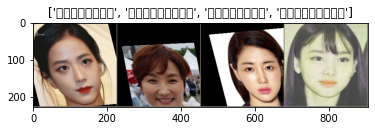

tensor([1, 0, 1, 2])


In [ ]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기

iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

print(classes)

In [ ]:
model = models.resnet34(pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
num_features = model.fc.in_features # cnn에서 feature extraction 후 fully connected 레이어에 입력된는 데이터 수 



# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 5개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()   # Loss 함수를 뜻 하는 criterion은 CrossEntropy 텐서 플로우로는 softmax같은 느낌 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 옵티마이저는 Stochastic Gradient Descent, ResNet34의 feature extraction 부분의 전체 웨이트 매트릭스를 넣어주는 것 

In [ ]:
def images_to_probs(model, images):
  output = model(images)
  _, preds = torch.max(outputs, 1)
  preds = np.squeeze(preds.numpy())
  return preds, [F.softmax(el, dim=0)[i].item() for i,el in zip(preds,output)]

def plot_classes_preds(model, images, labels):
  preds, probs = images_to_probs(model, images)
  fig = plt.figure(figsize=(12,48))
  for idx in np.arange(4):
    ax = fig.add_subplot(1,4,idx+1,xticks=[],yticks=[])
    matplotlib_imshow(images[idx], one_channel=True)
    ax.set_title("{0}, {1:.1f}%\n(label: {5}".format(
        class_names[preds[idx]],
        probs[idx]*100.0,
        class_names[labels[idx]]),
          color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


In [ ]:
num_epochs = 68
model.train()
start_time = time.time()
loss_value=[]
acc_value =[]
# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    loss_value.append (epoch_loss)
    acc_value.append(epoch_acc)
    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 1.7201 Acc: 29.1667% Time: 5.4602s
#1 Loss: 1.4785 Acc: 43.0556% Time: 10.4528s
#2 Loss: 1.6064 Acc: 43.8889% Time: 15.3749s
#3 Loss: 1.1953 Acc: 54.7222% Time: 20.3308s
#4 Loss: 1.2537 Acc: 55.2778% Time: 25.2613s
#5 Loss: 0.9940 Acc: 64.7222% Time: 30.2044s
#6 Loss: 0.9409 Acc: 68.6111% Time: 35.0766s
#7 Loss: 0.9473 Acc: 69.4445% Time: 40.0936s
#8 Loss: 0.8698 Acc: 68.3333% Time: 45.1412s
#9 Loss: 0.8797 Acc: 71.3889% Time: 50.0359s
#10 Loss: 0.6575 Acc: 77.7778% Time: 54.9285s
#11 Loss: 0.6615 Acc: 75.5556% Time: 59.9967s
#12 Loss: 0.6385 Acc: 78.6111% Time: 64.9668s
#13 Loss: 0.6367 Acc: 77.7778% Time: 69.9534s
#14 Loss: 0.6416 Acc: 80.0000% Time: 74.8815s
#15 Loss: 0.4260 Acc: 85.8333% Time: 79.8506s
#16 Loss: 0.3408 Acc: 87.2222% Time: 84.7540s
#17 Loss: 0.6199 Acc: 78.3333% Time: 89.6936s
#18 Loss: 0.5477 Acc: 80.0000% Time: 94.6260s
#19 Loss: 0.3960 Acc: 86.6667% Time: 99.5946s
#20 Loss: 0.5081 Acc: 83.3333% Time: 104.5444s
#21 Loss: 0.5279 Acc: 83.8889% Time: 109.551

Text(0, 0.5, 'Accuracy')

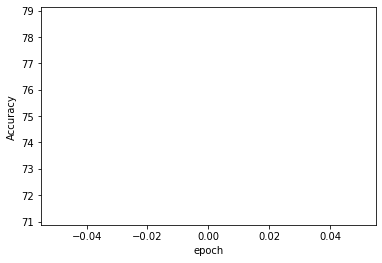

In [ ]:
plt.plot(acc_value, color='#9297ff')
plt.xlabel('epoch') 
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

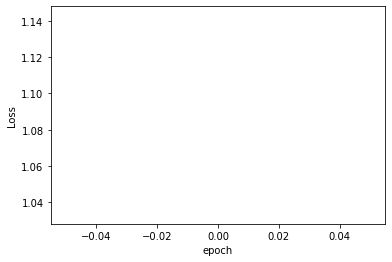

In [ ]:
plt.plot(loss_value, color='#9297ff')
plt.xlabel('epoch') 
plt.ylabel('Loss')

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/'

torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')